In [2]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer

## 🧠 Building Brains That See – The Story of Our SimpleCNN

Imagine teaching a child to recognize handwritten digits first, they look for edges, then patterns, and finally the full shape. Our CNN learns in the same way.

We start with **small eyes**:  
🔹 The first convolutional layer scans the grayscale image with 32 filters, it's like giving our model its first pair of glasses.

Then, we zoom out:  
🔹 MaxPooling cuts the view in half, helping the model focus on the *big picture*, not every pixel.

Next, we make it smarter:  
🔹 A second convolutional layer deepens its perception with 64 filters now it sees not just strokes, but combinations of them.

We zoom out again:  
🔹 Another MaxPooling layer reduces the details, keeping only what matters most.

Now comes the brainy part:  
🔹 We flatten all that spatial knowledge into a single long thought and pass it through two dense layers.  
🔹 The first one, with 128 neurons, does the heavy thinking.  
🔹 The final one decides which digit (0 to 9) did it see?

And just like that, we’ve built a tiny machine that learns to **see like us**.

> 📌 *This CNN is purposefully small, fast to train, easy to understand, and perfect for experimenting with adversarial attacks.*


In [4]:
# Simple CNN model for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

## 🧼 Preparing the Digits – From Raw Pixels to Ready-to-Learn

Before our neural network can *see*, it needs to understand the language of images tensors.

We start with a translator:  
🔹 `transforms.ToTensor()` takes raw images (pixels 0–255) and converts them into PyTorch tensors the native tongue of neural networks.

Then comes a balancing act:  
🔹 `transforms.Normalize((0.5,), (0.5,))` rescales pixel values from `[0, 1]` to `[-1, 1]`, ensuring the model doesn’t get overwhelmed by extremes a calm mind learns better.

Once transformed, we bring in the knowledge banks:  
📚 **MNIST** — the classic handwritten digit dataset split into training and testing worlds.

- 🏋️‍♂️ `train_loader`: 60,000 handwritten digits, shuffled and batched into groups of 64. Perfect for learning.
- 🧪 `test_loader`: 10,000 unseen digits, untouched by training — our final exam set.

This setup forms the **gateway** through which raw data becomes *understandable intelligence* for our CNN.


In [5]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader, test_loader

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


(<torch.utils.data.dataloader.DataLoader at 0x7f1395d565d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f13961bf490>)

## 🚀 Let the Learning Begin – Training Our Digit Classifier

Now that our data is ready, it’s time to bring our neural network to life.

We instantiate our **SimpleCNN** — a lightweight convolutional neural network designed to recognize digits from images. But even the most promising model needs a few companions:

- ⚙️ `optimizer = Adam(...)`: Think of this as the *coach*, constantly updating the model's game plan (weights) after each mistake.
- 📉 `criterion = CrossEntropyLoss()`: Our *referee* it tells the model how far off its predictions are from the truth.

### 🧠 Training the Brain
The `train()` function steps into the arena.

For each **epoch** (a full pass through the training data):
- We hand the model batches of digits and ask it to guess.
- The loss function shows how wrong the model is.
- The optimizer helps it get better — adjusting its parameters to improve next time.

Every 100 batches, we peek into its progress with a printed loss value.

### 📏 Putting It to the Test
After training, the `test()` function evaluates how well the model generalizes to unseen digits those it never studied.

- The model turns off learning mode with `.eval()`
- It goes through the test data, making predictions.
- We calculate the percentage of correct guesses: **Test Accuracy**.

---

🎉 **And just like that, our model starts thinking.** From knowing nothing about digits to recognizing them with surprising accuracy, this moment marks the birth of intelligence inside code.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, criterion, device, epochs=5):
    """
    🎓 Trains the given neural network model on labeled image data.

    For each epoch, this function:
    - Feeds input data to the model in mini-batches.
    - Calculates prediction loss using a chosen criterion.
    - Propagates the error back and updates weights using the optimizer.

    Periodically prints loss to show learning progress.

    Args:
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): Loader for training dataset.
        optimizer (torch.optim.Optimizer): Optimization algorithm (e.g., Adam).
        criterion (nn.Module): Loss function to measure prediction error.
        epochs (int): Number of training cycles over the dataset (default: 5).
    """
    model.train()

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move to device

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

def test(model, test_loader, device):
    """
    🧪 Evaluates the trained model’s performance on unseen test data.

    The model is set to evaluation mode to disable gradient calculations.
    It then:
    - Makes predictions batch-by-batch.
    - Compares predictions with actual labels.
    - Calculates and prints overall classification accuracy.

    Returns:
        float: Test accuracy as a percentage (% of correctly predicted digits).
    """
    model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move to device
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

    return accuracy

print("Training initial model...")
train(model, train_loader, optimizer, criterion, device=device)

initial_accuracy = test(model, test_loader, device=device)
print(initial_accuracy)

Training initial model...
Epoch 1/5, Batch 0/938, Loss: 2.292902946472168
Epoch 1/5, Batch 100/938, Loss: 0.22396144270896912
Epoch 1/5, Batch 200/938, Loss: 0.1466895341873169
Epoch 1/5, Batch 300/938, Loss: 0.06374120712280273
Epoch 1/5, Batch 400/938, Loss: 0.11775147914886475
Epoch 1/5, Batch 500/938, Loss: 0.1421186774969101
Epoch 1/5, Batch 600/938, Loss: 0.03702366724610329
Epoch 1/5, Batch 700/938, Loss: 0.025663260370492935
Epoch 1/5, Batch 800/938, Loss: 0.12284591048955917
Epoch 1/5, Batch 900/938, Loss: 0.10919448733329773
Epoch 2/5, Batch 0/938, Loss: 0.0117986174300313
Epoch 2/5, Batch 100/938, Loss: 0.004859633278101683
Epoch 2/5, Batch 200/938, Loss: 0.00944727286696434
Epoch 2/5, Batch 300/938, Loss: 0.07876724749803543
Epoch 2/5, Batch 400/938, Loss: 0.07701323181390762
Epoch 2/5, Batch 500/938, Loss: 0.06706240028142929
Epoch 2/5, Batch 600/938, Loss: 0.08659479022026062
Epoch 2/5, Batch 700/938, Loss: 0.004884133581072092
Epoch 2/5, Batch 800/938, Loss: 0.0017161013

### 🔥 Adversarial Attack & Defense: Outsmarting the Intruder

Our neural network was performing beautifully clean MNIST digits, high accuracy, and everything looked great.  
But beneath the surface, there was a silent threat lurking.  
What if an attacker could nudge the pixels of an image just enough to fool the model, but not enough for a human to notice?

Welcome to the world of **adversarial examples**.

---

### ⚔️ Step 1: The First Breach — FGSM in Action

We used the **Fast Gradient Sign Method (FGSM)** to generate adversarial versions of our test dataset.  
These images looked almost identical to the originals but were carefully manipulated to mislead the model.

The result?  
The model, once confident and accurate, was now stumbling.  
Its predictions fell apart not because it lacked training, but because it had never seen such subtle deception before.

---

### 📉 The Aftermath — Measuring the Model's Collapse

Accuracy **plummeted**.  
The same classifier that aced the clean test set now **struggled**.  
The adversarial attack worked — proving just how fragile deep learning models can be when faced with intelligently crafted inputs.

This wasn't just a failure - it was a **wake-up call**.

---

### 🛡️ Step 2: Building a Defense — Adversarial Training

Instead of plugging one vulnerability, we built a **shield**.  
We retrained the model on a mix of clean and adversarial examples, teaching it to recognize both real and deceptive data.

This wasn’t just regular training - this was *survival training*.

Each epoch hardened the model’s intuition, slowly making it **robust** against the very attacks that had once broken it.

---

### ✅ Step 3: Testing the Shield — Did It Work?

We unleashed the same adversarial examples again, expecting the model to stumble once more.  
But this time... it held its ground.

The accuracy on adversarial samples improved significantly a strong sign that **adversarial training works**.

> From vulnerable to vigilant — the model had learned not just to see, but to *discern*.

---


In [7]:
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

print("Generating adversarial examples with FGSM...")

attack = FastGradientMethod(estimator=classifier, eps=0.8)

x_test = np.array([x.numpy() for x, _ in test_dataset])

x_test_adv = attack.generate(x=x_test)
x_test_adv = torch.from_numpy(x_test_adv).float()

y_test = torch.tensor([y for _, y in test_dataset])

predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == y_test.numpy()) / len(y_test)

print(f'Adversarial Test Accuracy: {accuracy_adv * 100}%')

print("Performing adversarial training...")
attacks = [FastGradientMethod(estimator=classifier, eps=0.2)]
trainer = AdversarialTrainer(classifier, attacks, ratio=0.5)

x_train = np.array([x.numpy() for x, _ in train_dataset])
y_train = np.array([y for _, y in train_dataset])

trainer.fit(x_train, y_train, nb_epochs=5)

predictions_adv_trained = classifier.predict(x_test_adv)
accuracy_adv_trained = np.sum(np.argmax(predictions_adv_trained, axis=1) == y_test.numpy()) / len(y_test)

print(f'Adversarial Test Accuracy after training: {accuracy_adv_trained * 100}%')

Generating adversarial examples with FGSM...
Adversarial Test Accuracy: 10.620000000000001%
Performing adversarial training...


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Adversarial Test Accuracy after training: 27.21%


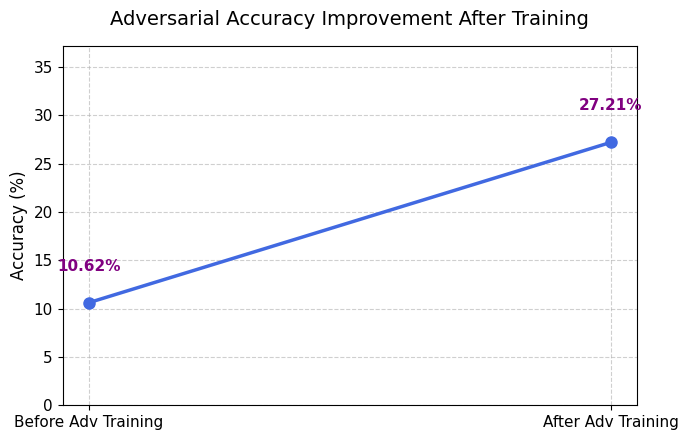

In [9]:
def plot_adversarial_accuracy_progression(before, after):
    """
    Plots a smooth line chart showing adversarial accuracy before and after training,
    with clean annotation and auto-adjusted spacing.

    Args:
        before (float): Accuracy on adversarial examples before training (0.0 - 1.0).
        after (float): Accuracy on adversarial examples after adversarial training (0.0 - 1.0).
    """
    stages = ['Before Adv Training', 'After Adv Training']
    accuracies = [before * 100, after * 100]

    # Extend y-limit slightly for cleaner layout
    max_acc = max(accuracies)
    y_max = min(100, max_acc + 10)  # cap at 100

    plt.figure(figsize=(7, 4.5))
    plt.plot(stages, accuracies, marker='o', linestyle='-', color='royalblue', linewidth=2.5, markersize=8)

    # Annotate each point slightly above with a shadow effect
    for i, acc in enumerate(accuracies):
        offset = 3 if acc < 95 else 1.5  # avoid touching top
        plt.text(i, acc + offset, f'{acc:.2f}%', ha='center', va='bottom',
                 fontsize=11, fontweight='bold', color='purple')

    plt.title('Adversarial Accuracy Improvement After Training', fontsize=14, pad=15)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.ylim(0, y_max)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_adversarial_accuracy_progression(accuracy_adv, accuracy_adv_trained)

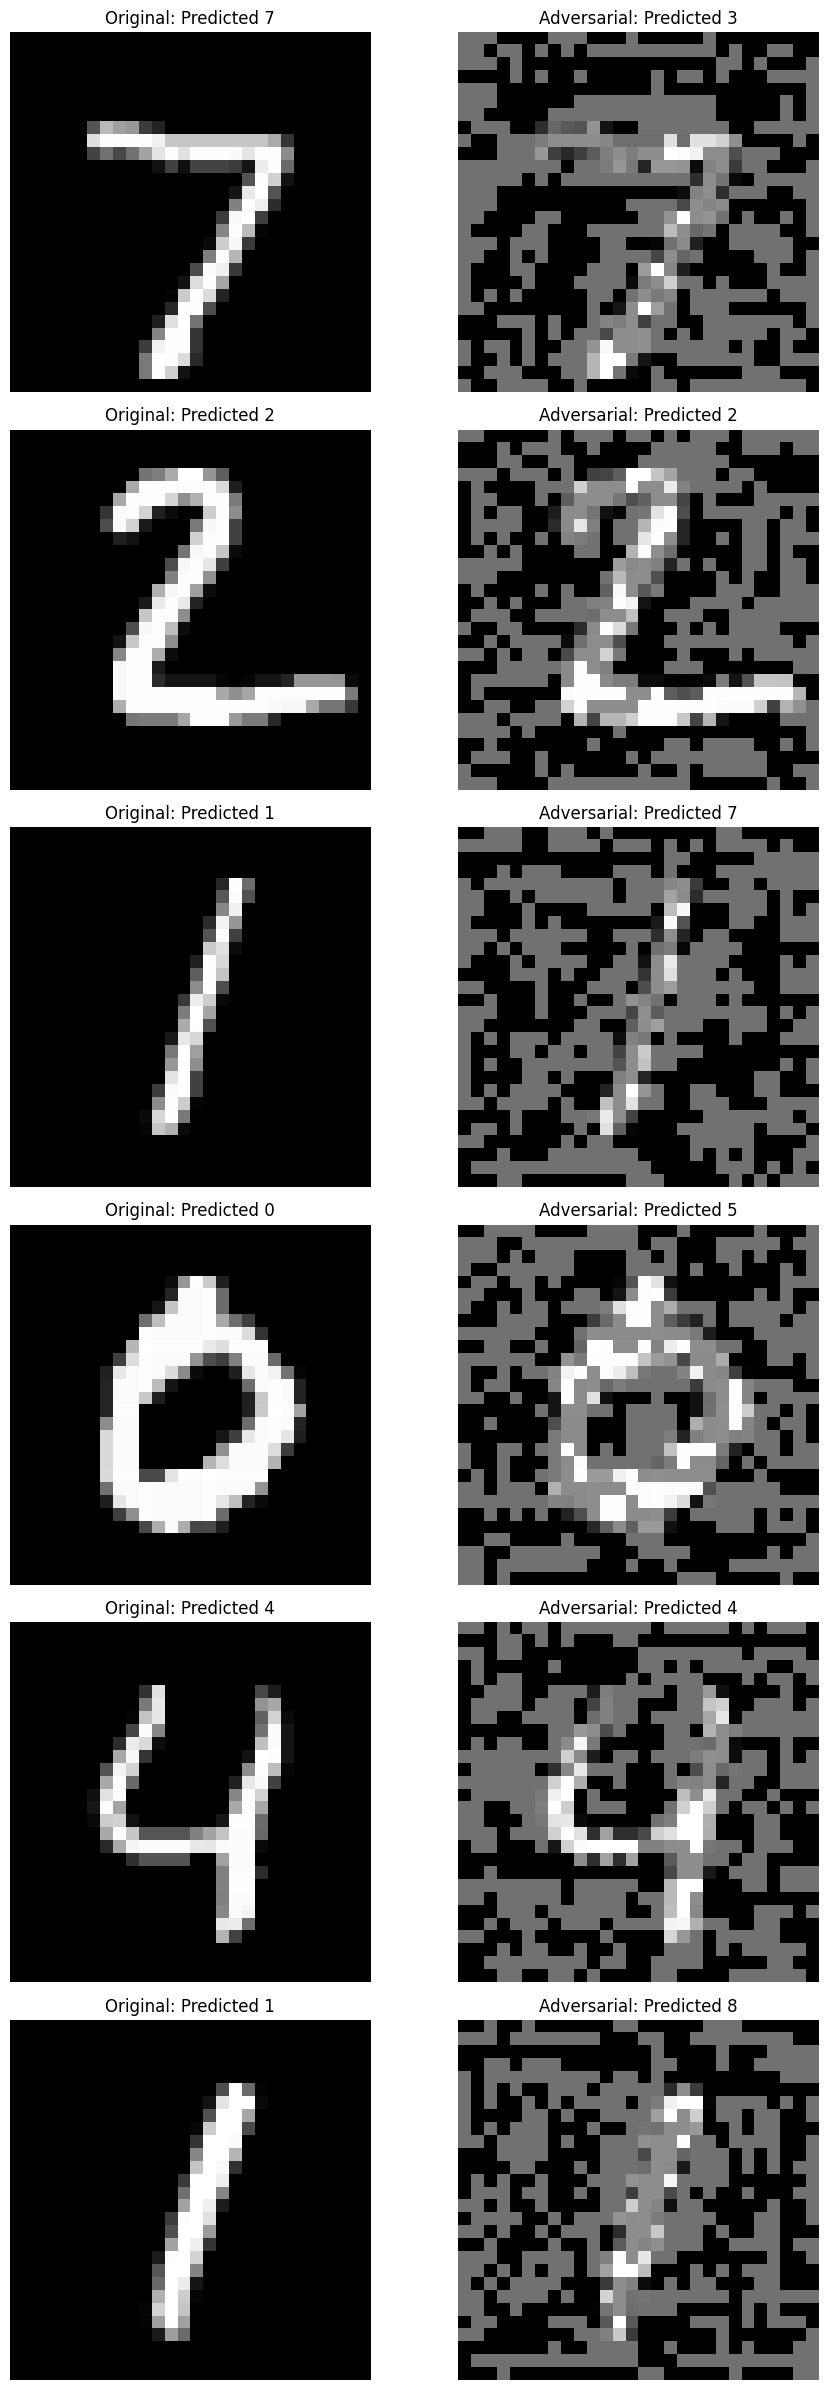


✅ All images saved in: /content/saved_images


In [10]:
from PIL import Image

def visualize_and_save_images(original, adversarial, classifier, num_images=5, save_dir="saved_images"):
    """
    Visualizes and saves side-by-side comparisons of original and adversarial images.

    The story begins with a trained classifier and two competing versions of the same image —
    one pure, one subtly corrupted. This function brings them to life by:
    - Running both images through the classifier to see how each is perceived.
    - Displaying them side-by-side with predictions on top.
    - Saving every comparison in neatly organized folders: original, adversarial, and combined.

    Parameters:
    - original (np.ndarray): Clean input images (e.g., from the test set).
    - adversarial (np.ndarray): Corresponding adversarially perturbed images.
    - classifier (object): A wrapper or model with a `.model` attribute (must be a PyTorch model).
    - num_images (int): How many image pairs to visualize and save. Default is 5.
    - save_dir (str): Root directory where all images will be saved. Default is 'saved_images'.

    Returns:
    - None. Saves images to disk and shows a matplotlib plot comparing predictions.
    """

    classifier.model.eval()

    device = next(classifier.model.parameters()).device  # Get model device

    original_tensor = torch.from_numpy(original[:num_images]).float().to(device)
    adversarial_tensor = torch.from_numpy(adversarial[:num_images]).float().to(device)

    with torch.inference_mode():
        original_preds = classifier.model(original_tensor).argmax(dim=1).cpu().numpy()
        adversarial_preds = classifier.model(adversarial_tensor).argmax(dim=1).cpu().numpy()

    save_path = Path(save_dir)
    (save_path / "original").mkdir(parents=True, exist_ok=True)
    (save_path / "adversarial").mkdir(parents=True, exist_ok=True)
    (save_path / "combined").mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 4 * num_images))

    for i in range(num_images):
        orig_img = original[i].squeeze()
        adv_img = adversarial[i].squeeze()

        orig_pred = original_preds[i]
        adv_pred = adversarial_preds[i]

        # Plot for visualization
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(orig_img, cmap='gray')
        plt.title(f'Original: Predicted {orig_pred}')
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(adv_img, cmap='gray')
        plt.title(f'Adversarial: Predicted {adv_pred}')
        plt.axis('off')

        # Convert to PIL and save
        orig_img_clipped = np.clip(orig_img, 0, 1)
        orig_pil = Image.fromarray((orig_img_clipped * 255).astype("uint8"))

        adv_img_clipped = np.clip(adv_img, 0, 1)
        adv_pil = Image.fromarray((adv_img_clipped * 255).astype("uint8"))

        orig_pil.save(save_path / "original" / f"original_{i}_pred_{orig_pred}.png")
        adv_pil.save(save_path / "adversarial" / f"adversarial_{i}_pred_{adv_pred}.png")

        # Create combined side-by-side image
        combined = Image.new("L", (orig_pil.width * 2, orig_pil.height))
        combined.paste(orig_pil, (0, 0))
        combined.paste(adv_pil, (orig_pil.width, 0))
        combined.save(save_path / "combined" / f"compare_{i}_orig_{orig_pred}_adv_{adv_pred}.png")

    plt.tight_layout()
    plt.show()
    print(f"\n✅ All images saved in: {save_path.absolute()}")

visualize_and_save_images(x_test, x_test_adv.numpy(), classifier, num_images=6)

In [11]:
# Let's save this model
my_model_path = Path("models")
my_model_path.mkdir(parents=True, exist_ok=True)
model_name = "IBM_ART_Poisoning_attack2.pth"

full_path_name = my_model_path / model_name
torch.save(model.state_dict(), full_path_name)

print(f"Model is successfully saved at: {full_path_name}")

Model is successfully saved at: models/IBM_ART_Poisoning_attack2.pth


```python
# 🧠 Step 1: Save the Trained Model
# After training our classifier to handle both clean and adversarial examples,
# we save its learned parameters. This allows us to reuse the model later
# without retraining from scratch.

torch.save(model.state_dict(), "IBM_ART_Poisoning_attack.pth")

# ⚔️ Step 2: Load the Saved Model
# To evaluate the model or visualize its performance, we reload it.
# This step is crucial especially when switching from training to inference.

model.load_state_dict(torch.load("IBM_ART_Poisoning_attack.pth"))
model.eval()  # Set to evaluation mode to disable dropout, etc.

# 🧠 Step 3: Initialize the ART Classifier
# After training the model, we wrap it using Adversarial Robustness Toolbox's PyTorchClassifier.
# This wrapper enables us to perform training, evaluation, and adversarial attacks in a standardized way.

classifier = PyTorchClassifier(
    model=model,                  # Your trained PyTorch model
    loss=criterion,                # Loss function used during training (e.g., CrossEntropyLoss)
    optimizer=optimizer,           # Optimizer used (e.g., Adam or SGD)
    input_shape=(1, 28, 28),       # Input shape of MNIST images
    nb_classes=10                  # Total number of output classes
)

# 🖼️ Step 4: Visualize Predictions on Original vs Adversarial Samples
# We use a custom visualization function to compare how the model performs
# on clean images versus adversarially perturbed ones.
# It displays predictions and saves all comparison images to disk.

visualize_and_save_images(
    original=x_test,
    adversarial=x_test_adv.numpy(),
    classifier=classifier,
    num_images=6  # Number of images to visualize and save
)
```


In [12]:
model2 = SimpleCNN()
my_model_path = Path("models")
model_name = "IBM_ART_Poisoning_attack2.pth"

full_path_name = my_model_path / model_name
model2.load_state_dict(torch.load(full_path_name))
model2.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [14]:
classifier2 = PyTorchClassifier(
    model=model2,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

classifier2

art.estimators.classification.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (relu): ReLU()
  )
), loss=CrossEntropyLoss(), optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), input_shape=(1, 28, 28), nb_classes=10, channels_first=True, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=StandardisationMeanStdPyTorch(mean=0.0, std=1.0, apply_fit=True, apply_predict=True, device=cu

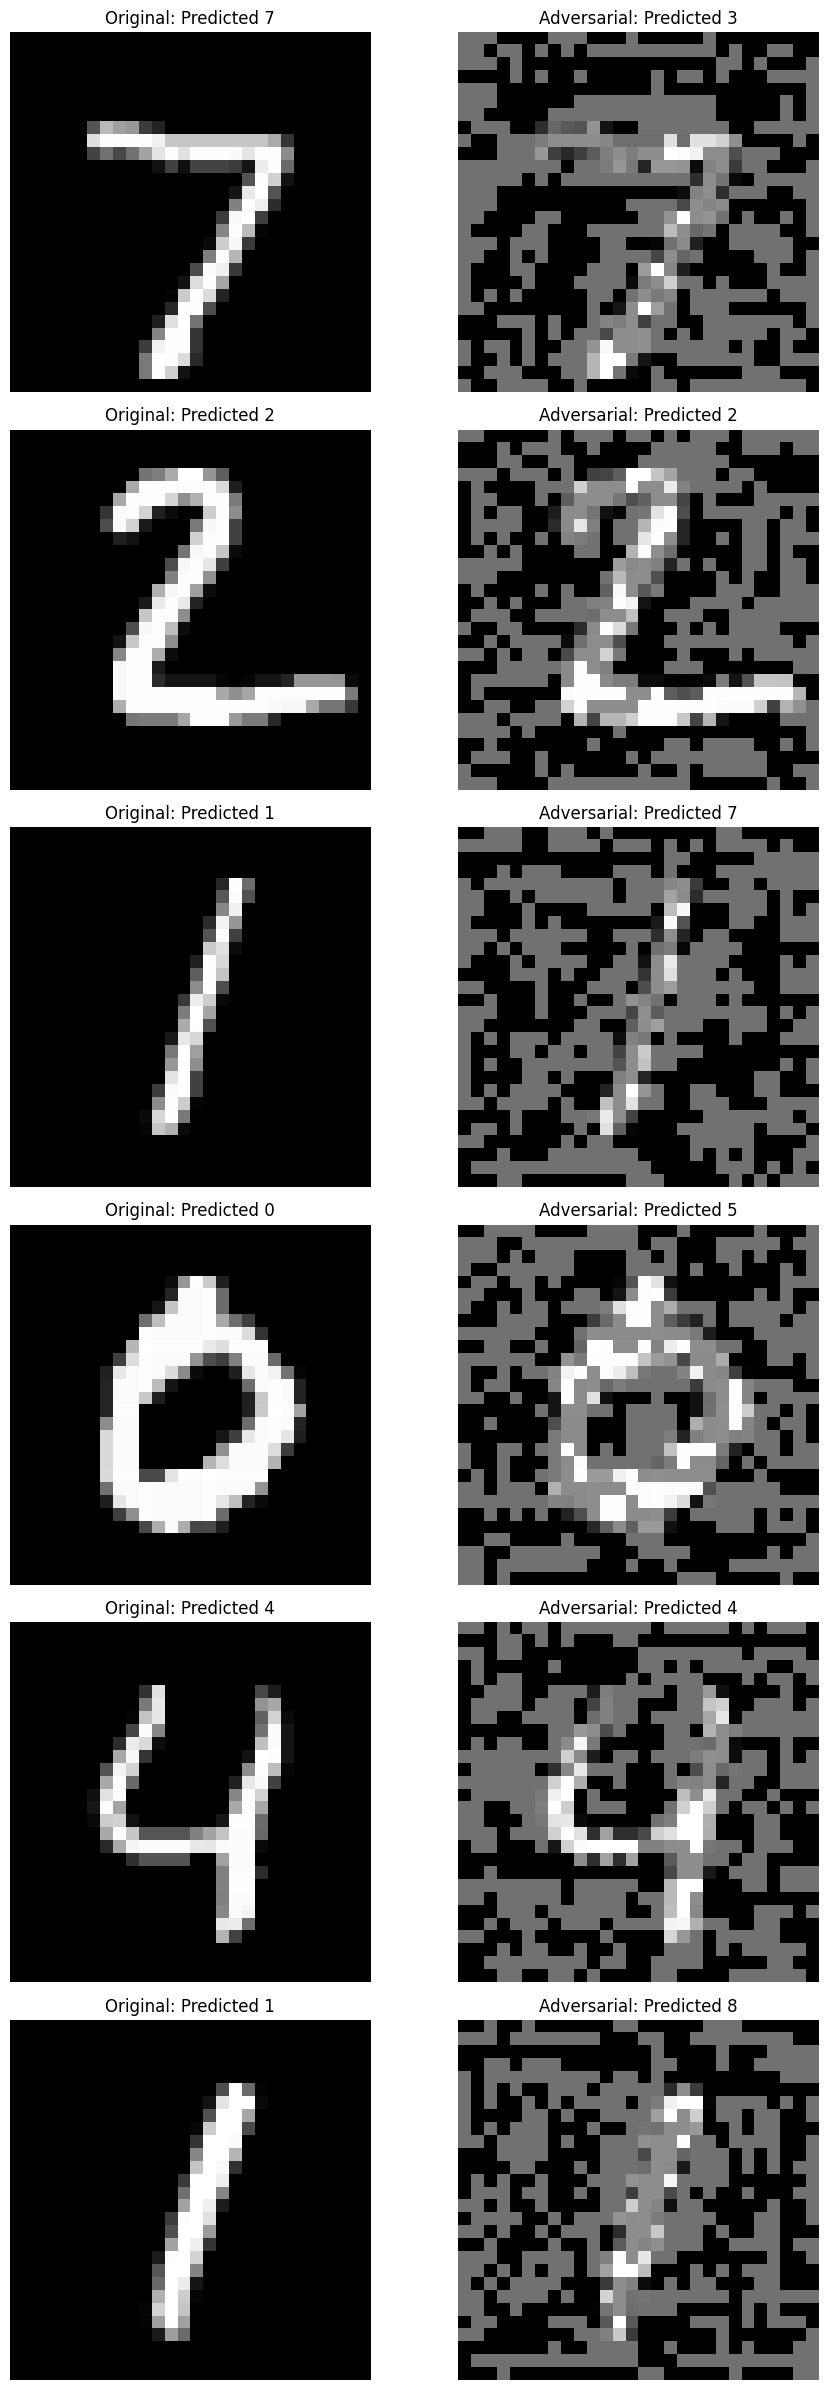


✅ All images saved in: /content/saved_images


In [15]:
visualize_and_save_images(x_test, x_test_adv.numpy(), classifier2, num_images=6)